In [54]:
# =============================================================================
# Notebook: 01_data_prep.ipynb
# =============================================================================

# Section 1: Imports & RNG
import pandas as pd
import numpy as np

rng = np.random.default_rng(42)

# Section 2: Load raw files
ins  = pd.read_csv('insurance_data.csv', parse_dates=['LOSS_DT'])
emp  = pd.read_csv('employee_data.csv')
vend = pd.read_csv('vendor_data.csv')

# Section 3: Keep personal-auto only
ins = ins[ins["INSURANCE_TYPE"].str.lower() == "motor"].copy()

# Section 4: Engineer core fields
ins["earned_car_year"] = ins["TENURE"] / 12.0
ins["claim_count"]     = (ins["CLAIM_AMOUNT"] > 0).astype(int)
ins["accident_year"]   = ins["LOSS_DT"].dt.year

# Section 5: Simulate missing pieces
ins["vehicle_seg"] = rng.choice(
    ["SmallCar", "SUV", "Truck"],
    p=[.50, .35, .15],
    size=len(ins)
)
ins["dev_months"]  = rng.choice(
    [3, 6, 12, 24],
    p=[.35, .35, .20, .10],
    size=len(ins)
)

# Section 6: Merge agent & vendor (if keys exist)
if "AGENT_ID" in ins.columns and "AGENT_ID" in emp.columns:
    ins = ins.merge(emp, on="AGENT_ID", how="left", suffixes=("", "_emp"))
if "VENDOR_ID" in ins.columns and "VENDOR_ID" in vend.columns:
    ins = ins.merge(vend, on="VENDOR_ID", how="left", suffixes=("", "_vend"))

# Section 7: Build & save incremental triangle
inc = ins[["accident_year", "dev_months", "CLAIM_AMOUNT"]].copy()
inc["incremental_paid"] = inc["CLAIM_AMOUNT"]
inc.to_csv("triangle_incremental.csv", index=False)

# Section 8: Prepare GLM-ready dataset
cols = [
    "POLICY_NUMBER", "earned_car_year", "CLAIM_AMOUNT", "claim_count",
    "accident_year", "dev_months", "AGE", "vehicle_seg", "INCIDENT_STATE"
]
for c in ["policy_csl", "policy_deductable"]:
    if c in ins.columns:
        cols.append(c)

glm_df = ins[cols].copy()
glm_df = glm_df.rename(columns={
    "CLAIM_AMOUNT": "paid_loss",
    "AGE": "age",
    "INCIDENT_STATE": "incident_state"
})
glm_df["age_band"] = pd.cut(
    glm_df["age"],
    bins=[0, 24, 39, 64, 120],
    labels=["<25", "25-39", "40-64", "65+"]
)

glm_df.to_csv("auto_policy_clean.csv", index=False)

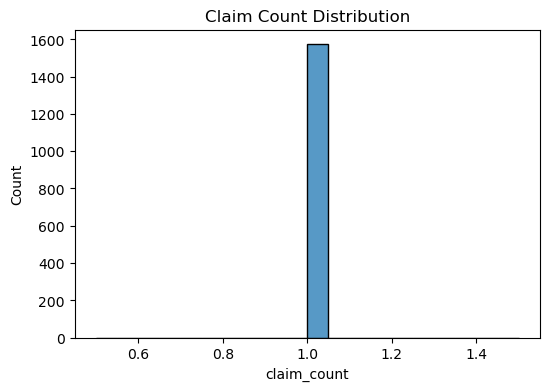

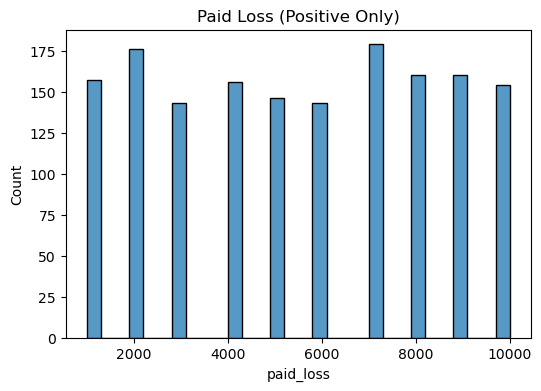

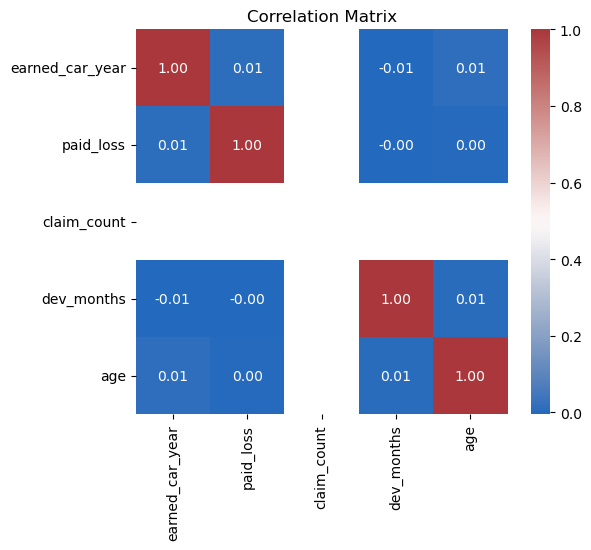

                 Generalized Linear Model Regression Results                  
Dep. Variable:            claim_count   No. Observations:                 1574
Model:                            GLM   Df Residuals:                     1555
Model Family:                 Poisson   Df Model:                           18
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1889.0
Date:                Tue, 03 Jun 2025   Deviance:                       629.95
Time:                        22:50:35   Pearson chi2:                 1.07e+03
No. Iterations:                     5   Pseudo R-squ. (CS):           0.002494
Covariance Type:            nonrobust                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


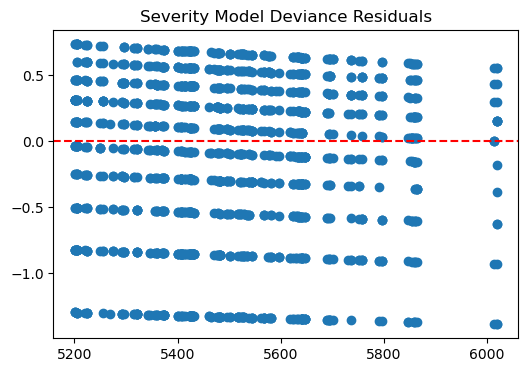

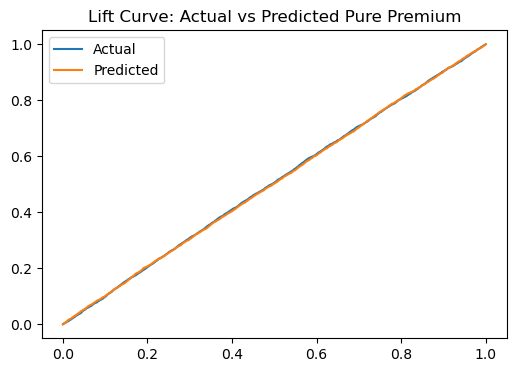

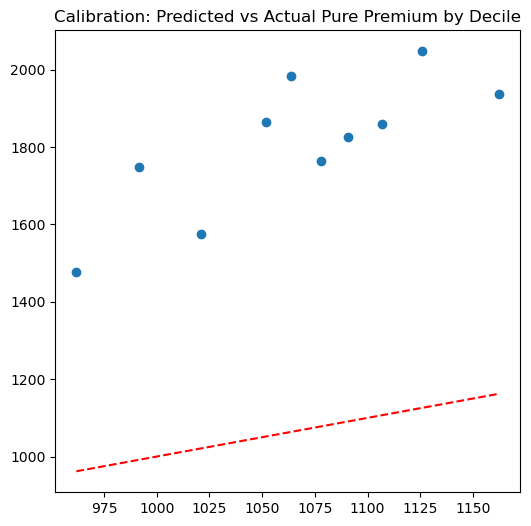

In [60]:
# =============================================================================
# Notebook: 02_glm_pricing.ipynb
# =============================================================================

# Section 1: Imports
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

# Section 2: Load GLM dataset
glm_df = pd.read_csv("auto_policy_clean.csv")

# Section 3: EDA
plt.figure(figsize=(6,4))
sns.histplot(glm_df["claim_count"], bins=20, kde=False)
plt.title("Claim Count Distribution")
plt.show()

plt.figure(figsize=(6,4))
sns.histplot(glm_df.loc[glm_df["paid_loss"] > 0, "paid_loss"], bins=30, kde=False)
plt.title("Paid Loss (Positive Only)")
plt.show()

num_cols = ["earned_car_year", "paid_loss", "claim_count", "dev_months", "age"]
plt.figure(figsize=(6,5))
sns.heatmap(glm_df[num_cols].corr(), annot=True, fmt=".2f", cmap="vlag")
plt.title("Correlation Matrix")
plt.show()

# Section 4: Frequency GLM (Poisson)
glm_df["log_exposure"] = np.log(glm_df["earned_car_year"] + 1e-6)
freq_formula = "claim_count ~ C(age_band) + C(vehicle_seg) + C(incident_state)"
freq_model = smf.glm(
    formula=freq_formula,
    data=glm_df,
    family=sm.families.Poisson(),
    offset=glm_df["log_exposure"]
).fit()
print(freq_model.summary())
glm_df["pred_frequency"] = freq_model.predict(glm_df)

# Section 5: Severity GLM (Gamma)
sev_df = glm_df[glm_df["paid_loss"] > 0].copy()
sev_formula = "paid_loss ~ C(age_band) + C(vehicle_seg) + C(incident_state)"
sev_model = smf.glm(
    formula=sev_formula,
    data=sev_df,
    family=sm.families.Gamma(link=sm.families.links.log())
).fit()
print(sev_model.summary())
glm_df["pred_severity"] = 0.0
glm_df.loc[glm_df["paid_loss"] > 0, "pred_severity"] = sev_model.predict(sev_df)

# Section 6: Pure Premium & Class Relativities
glm_df["pred_pure_premium"] = glm_df["pred_frequency"] * glm_df["pred_severity"]
overall_pp = glm_df["paid_loss"].sum() / glm_df["earned_car_year"].sum()
glm_df["relativity"] = glm_df["pred_pure_premium"] / overall_pp

rel_table = (
    glm_df
    .groupby(["incident_state", "age_band"])
    .agg(
        avg_pp         = ("pred_pure_premium", "mean"),
        avg_relativity = ("relativity", "mean"),
        total_exposure = ("earned_car_year", "sum")
    )
    .reset_index()
)

K = 50
rel_table["cred_weight"] = rel_table["total_exposure"] / (rel_table["total_exposure"] + K)
rel_table["cred_pp"] = (
    rel_table["cred_weight"] * rel_table["avg_pp"] +
    (1 - rel_table["cred_weight"]) * overall_pp
)

rel_table.to_csv("relativity_table.csv", index=False)

# Section 7: Diagnostics
pearson_chi2 = ((freq_model.resid_pearson) ** 2).sum()
df_resid     = freq_model.df_resid
print(f"Frequency Model: Pearson χ² = {pearson_chi2:.2f}, DF resid = {df_resid:.0f}")

plt.figure(figsize=(6,4))
plt.scatter(sev_model.fittedvalues, sev_model.resid_deviance)
plt.axhline(0, color="red", linestyle="--")
plt.title("Severity Model Deviance Residuals")
plt.show()

glm_df["actual_pp"] = glm_df["paid_loss"] / glm_df["earned_car_year"]
glm_df["pred_pp"]    = glm_df["pred_pure_premium"]
glm_df = glm_df.dropna(subset=["pred_pp", "actual_pp"])
glm_df = glm_df.sort_values("pred_pp", ascending=False).reset_index(drop=True)
glm_df["cum_actual_loss"]   = glm_df["paid_loss"].cumsum()
glm_df["cum_expected_loss"] = (glm_df["pred_pp"] * glm_df["earned_car_year"]).cumsum()
tot_actual   = glm_df["paid_loss"].sum()
tot_expected = (glm_df["pred_pp"] * glm_df["earned_car_year"]).sum()

plt.figure(figsize=(6,4))
plt.plot(
    np.arange(1, len(glm_df)+1) / len(glm_df),
    glm_df["cum_actual_loss"] / tot_actual,
    label="Actual"
)
plt.plot(
    np.arange(1, len(glm_df)+1) / len(glm_df),
    glm_df["cum_expected_loss"] / tot_expected,
    label="Predicted"
)
plt.title("Lift Curve: Actual vs Predicted Pure Premium")
plt.legend()
plt.show()

glm_df["pp_decile"] = pd.qcut(glm_df["pred_pp"], 10, labels=False)
calib = glm_df.groupby("pp_decile").agg(
    actual_rate=("actual_pp", "mean"),
    pred_rate=("pred_pp", "mean")
).reset_index()

plt.figure(figsize=(6,6))
plt.plot(calib["pred_rate"], calib["actual_rate"], "o")
plt.plot(
    [calib["pred_rate"].min(), calib["pred_rate"].max()],
    [calib["pred_rate"].min(), calib["pred_rate"].max()],
    "r--"
)
plt.title("Calibration: Predicted vs Actual Pure Premium by Decile")
plt.show()

In [68]:
# =============================================================================
# Notebook: 03_reserving_capital.ipynb
# =============================================================================

# Section 1: Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

try:
    import pandas_chainladder as pcl
    pcl_installed = True
except ImportError:
    pcl_installed = False

# Section 2: Load incremental triangle data
inc = pd.read_csv("triangle_incremental.csv")

inc_tri = inc.pivot_table(
    index="accident_year",
    columns="dev_months",
    values="incremental_paid",
    aggfunc="sum"
).fillna(0).sort_index()

cum_tri = inc_tri.cumsum(axis=1)
cum_tri.columns = list(map(int, cum_tri.columns))

print("Cumulative Paid Loss Triangle:")
display(cum_tri)

# Section 3: Mack Chain-Ladder IBNR
if pcl_installed:
    mack = pcl.MackChainladder(cum_tri)
    mack.run()
    ultimate = mack.ultimate
    reported = cum_tri.iloc[:, -1]
    mack_ibnr = ultimate - reported
    print("Mack IBNR by Accident Year:")
    print(mack_ibnr)
else:
    mack_ibnr = pd.Series(index=cum_tri.index, data=np.nan)
    print("Skipping Mack (pandas_chainladder not installed)")

# Section 4: Bornhuetter-Ferguson (BF)
glm_df      = pd.read_csv("auto_policy_clean.csv")
overall_pp  = glm_df["paid_loss"].sum() / glm_df["earned_car_year"].sum()
earned_by_ay = glm_df.groupby("accident_year")["earned_car_year"].sum()
expected_ult = earned_by_ay * overall_pp
reported_to_date = cum_tri.sum(axis=1).reindex(expected_ult.index, fill_value=0)
bf_ibnr = expected_ult - reported_to_date

print("BF IBNR by Accident Year:")
print(bf_ibnr)

# Section 5: Compare Mack vs BF
compare_df = pd.DataFrame({
    "accident_year": cum_tri.index,
    "reported": reported_to_date.values,
    "expected_ultimate": expected_ult.values,
    "mack_ibnr": mack_ibnr.values,
    "bf_ibnr": bf_ibnr.values
})
print("Reserving Comparison:")
display(compare_df)

# Section 6: Bootstrap Capital Model
if pcl_installed:
    boot = pcl.BootstrapMackChainladder(cum_tri, n_iterations=10000)
    boot.run()
    ult_mat = boot.ultimate
    total_ult = ult_mat.sum(axis=0).values
    var_995_base = np.quantile(total_ult, 0.995)
    print(f"Base 99.5% VaR = {var_995_base:,.0f}")

    expected_total_ult = expected_ult.sum()
    avail_capital = 1.5 * expected_total_ult
    rbc_base = avail_capital / var_995_base
    print(f"Base RBC Ratio = {rbc_base:.2f}")

    sens_results = []
    for infl in [1.03, 1.05]:
        adj_tri = cum_tri * infl
        boot_adj = pcl.BootstrapMackChainladder(adj_tri, n_iterations=5000)
        boot_adj.run()
        total_adj = boot_adj.ultimate.sum(axis=0).values
        var_adj = np.quantile(total_adj, 0.995)
        rbc_adj = avail_capital / var_adj
        sens_results.append({
            "inflation_factor": infl,
            "var_995": var_adj,
            "rbc_ratio": rbc_adj
        })

    sens_df = pd.DataFrame(sens_results)
    print("\nVaR Sensitivity to Severity Inflation:")
    display(sens_df)

    plt.figure(figsize=(6,4))
    plt.bar(
        x=sens_df["inflation_factor"].map({1.03: "+3%", 1.05: "+5%"}),
        height=sens_df["var_995"],
        color="gray"
    )
    plt.axhline(var_995_base, color="red", linestyle="--", label="Base VaR")
    plt.title("VaR 99.5% under Severity Inflation (Tornado)")
    plt.ylabel("99.5% VaR")
    plt.legend()
    plt.show()

    var_995_final = var_995_base
    rbc_final    = rbc_base
else:
    var_995_final = np.nan
    rbc_final    = np.nan
    sens_df      = pd.DataFrame()

# Section 7: Save outputs
out_df = compare_df.copy()
out_df["var_995"]   = var_995_final
out_df["rbc_ratio"] = rbc_final
out_df["sens_3%"]   = sens_df.loc[sens_df["inflation_factor"]==1.03, "rbc_ratio"].values[0] if not sens_df.empty else np.nan
out_df["sens_5%"]   = sens_df.loc[sens_df["inflation_factor"]==1.05, "rbc_ratio"].values[0] if not sens_df.empty else np.nan

out_df.to_csv("reserve_and_capital_results.csv", index=False)
print("Saved outputs to 'data/processed/reserve_and_capital_results.csv'")

Cumulative Paid Loss Triangle:


,3,6,12,24
accident_year,,,,
2020,1757000,3395000,4429000,4911000
2021,1280000,2635000,3366000,3752000


Skipping Mack (pandas_chainladder not installed)
BF IBNR by Accident Year:
accident_year
2020   -9.569710e+06
2021   -7.292290e+06
dtype: float64
Reserving Comparison:


,accident_year,reported,expected_ultimate,mack_ibnr,bf_ibnr
0,2020,14492000,4.922290e+06,NaN,-9.569710e+06
1,2021,11033000,3.740710e+06,NaN,-7.292290e+06


Saved outputs to 'data/processed/reserve_and_capital_results.csv'
